### Steps for clustering algorithm (what has been done manually and now needs to be automated)

1. Seasonality : 4 hour window periods
2. Standard deviation for 4 hour periods
3. Timestamps matched for carbohydrate intake (i.e. all 35g CHO within 1 hour of eachother grouped together)
4. Rate of glucose appearance and disappearance<br>
    *a. Glucose excursion (nadir to peak / peak to nadir) - +ve and -ve trends*<br>
    *b. iAUC (nadir to peak / peak to nadir) - +ve and -ve trends*
5. Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 
6. Incude the Carbs consumed in the 4 hour period
7. Collate the results of the above points into a data set with columns names:
    * Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)  
    * Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
    * Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
    * Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
    * Time period Number (1 / 2 / 3 / 4 / 5)
    * iAUC (+ve)
    * iAUC (-ve)
    * Glucose Excursion (+ve)
    * Glucose Excursion (-ve)
    * Total change in BG (+ve)
    * Total change in BG (-ve)
    * Peak value
    * Carbs
8. Run Clustering Algorithm
9. Goodness of fit assessment :
    * Want the algorithm to be adaptive.
    * Have the left overs recycled through the 'rules' missing the glucose excursion but maintaining the iAUC and total change in BG.
    * Then further iterations miss out the iAUC and review total change in BG etc

First things first:
Import/load necessary libraries 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime, date
import calendar
import time

from datetime import timedelta
from statistics import mode

%matplotlib inline

Load and preprocess necessary data sets

In [11]:
# Import data
def read_data(filename):
    #     unfiltered = pd.read_csv('./CSV Files/544_data.csv')
    unfiltered = pd.read_csv(os.path.join("CSV Files", filename))
    unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'], format="%d/%m/%Y %H:%M")
    unfiltered.drop('glucose_level_mmol/L', axis=1)
    return unfiltered

In [12]:
unfiltered = read_data('544_data.csv')
unfiltered

,glucose_level_ts,glucose_level_mg/dL,glucose_level_mmol/L,carbs_g,meal_ts,meal_type,bolus_dose,bolus_start_ts,bolus_end_ts,bolus_type
0,2020-05-11 00:02:00,129,NaN,135.0,11/05/2020 11:25,Lunch,7.1,11/05/2020 08:24,11/05/2020 08:24,normal
1,2020-05-11 00:07:00,128,NaN,100.0,11/05/2020 17:16,Dinner,16.8,11/05/2020 11:24,11/05/2020 11:24,normal
2,2020-05-11 00:12:00,129,NaN,42.0,11/05/2020 21:26,Snack,14.2,11/05/2020 17:19,11/05/2020 17:19,normal
3,2020-05-11 00:17:00,131,NaN,37.0,12/05/2020 08:02,Breakfast,7.5,11/05/2020 21:23,11/05/2020 21:23,normal
4,2020-05-11 00:22:00,133,NaN,78.0,12/05/2020 12:07,Lunch,6.9,12/05/2020 08:00,12/05/2020 08:00,normal
...,...,...,...,...,...,...,...,...,...,...
13334,2020-07-04 20:57:00,296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13335,2020-07-04 21:02:00,292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13336,2020-07-04 21:07:00,284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13337,2020-07-04 21:12:00,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Here we filter the unfiltered for glucose level and glucose_ts to use in isolating the glucose events.
# We will pick up the unfiltered datset again later when looking at CHO and Insulin levels.

features = ['glucose_level_ts', 'glucose_level_mg/dL']
data = unfiltered[features].copy()

# Convert timestamp to datetime format
#data['glucose_level_ts'] = pd.to_datetime(data['glucose_level_ts'])

# Map day of week names to day of week numbers
data['day_of_week'] = data['glucose_level_ts'].dt.dayofweek
data['day_of_week_name'] = data['glucose_level_ts'].dt.day_name()

time_step = mode(data['glucose_level_ts'].diff())
time_step_minutes = time_step/timedelta(minutes=1)
# assert(time_step_minutes == 5)
# # What if the assertion fails?

# Calculate rate of change
data['BG Rate of Change'] = data['glucose_level_mg/dL'].diff() / time_step_minutes
# (data['glucose_level_mg/dL'].shift(-1) - data['glucose_level_mg/dL']) / 5
data['bg_rate_of_change'] = data['glucose_level_mg/dL'].diff() / time_step_minutes

data

# plt.plot(data['glucose_level_mg/dL'])   

,glucose_level_ts,glucose_level_mg/dL,day_of_week,day_of_week_name,BG Rate of Change,bg_rate_of_change
0,2020-05-11 00:02:00,129,0,Monday,NaN,NaN
1,2020-05-11 00:07:00,128,0,Monday,-0.2,-0.2
2,2020-05-11 00:12:00,129,0,Monday,0.2,0.2
3,2020-05-11 00:17:00,131,0,Monday,0.4,0.4
4,2020-05-11 00:22:00,133,0,Monday,0.4,0.4
...,...,...,...,...,...,...
13334,2020-07-04 20:57:00,296,5,Saturday,0.0,0.0
13335,2020-07-04 21:02:00,292,5,Saturday,-0.8,-0.8
13336,2020-07-04 21:07:00,284,5,Saturday,-1.6,-1.6
13337,2020-07-04 21:12:00,273,5,Saturday,-2.2,-2.2


Step 2:

Isolate the peak and nadir (low) points in the set windows

In [14]:
import plotly.graph_objs as go
import plotly.offline as pyo
from scipy.signal import find_peaks

# sliced data set into 4 hour segments
timestamp = np.array(data['glucose_level_ts'], dtype=float)
glucose = np.array(data['glucose_level_mg/dL'], dtype=float)
elements_per_4hours = 48  # 48 BG samples in 4 hours sample
glucose_seg_ts = [timestamp[i:i+elements_per_4hours] for i in range(0, len(data), elements_per_4hours)]
glucose_sliced = [glucose[i:i+elements_per_4hours] for i in range(0, len(data), elements_per_4hours)]

glucose_segment = glucose_sliced[2] #selecting the 3rd segment, for example
glucose_segment_ts = glucose_seg_ts[2] 

prominence = 3.6*5 # mg/dL

# Add in Thresholds

print("Length of glucose segment:", len(glucose_segment))

# find peaks and troughs
peaks, _ = find_peaks(glucose_segment)
troughs, _ = find_peaks(-glucose_segment)

# Print peaks and troughs
print("Peaks: ", peaks)
print("Troughs: ", troughs)

# Check the length of the peaks and troughs lists
print("Length of peaks:", len(peaks))
print("Length of troughs:", len(troughs))

Length of glucose segment: 48
Peaks:  [29 32 43]
Troughs:  [ 9 30 37]
Length of peaks: 3
Length of troughs: 3


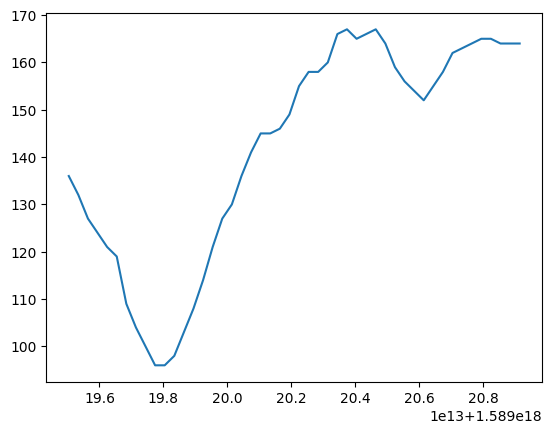

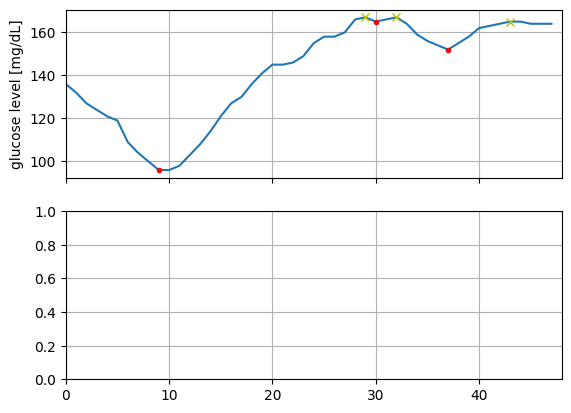

In [15]:
plt.plot(glucose_segment_ts, glucose_sliced[2])

_, ax = plt.subplots(2, sharex=True)
for j in [0,1]: ax[j].grid()

window_days = 1
offset = 0 # days from start (change this to look at other weeks)

ax[0].plot(glucose_sliced[2])
ax[0].plot(peaks, glucose_segment[peaks], "yx")
ax[0].plot(troughs, glucose_segment[troughs], "r.")
ax[0].set_ylabel('glucose level [mg/dL]')
ax[0].set_xlim(offset*(4*60/5), (offset+window_days)*4*60/5)

plt.show()

Isolate the Glucose Events (initial low, peak and secondary low)

In [16]:
events = []

print(f"Before loop: glucose_segment={glucose_segment.shape}")

# Set time threshold values for glycemic events
max_nadir_to_peak_time = timedelta(hours=2)
max_peak_to_2nd_nadir_time = timedelta(hours=4)
max_peak_to_peak_time = timedelta(hours=6)

for i in range(len(glucose_segment)):
    glucose_segment_i = glucose_sliced[i]

    # Find the corresponding timestamps for the glucose segment
    glucose_segment_ts_i = glucose_seg_ts[i]

    # find peaks and troughs
    peaks, _ = find_peaks(glucose_segment_i)
    troughs, _ = find_peaks(-glucose_segment_i)

    VERBOSE = False #False # set to True for parameter tuning/debugging

    # Ignore peaks that appear before any nadirs, or that have no (secondary) nadir afterwards
    ignored_peaks = (peaks < troughs[0]) | (peaks > troughs[-1])  

    counter =0
    # Loop through all peaks
    for j, idx in enumerate(peaks):
        
        if ignored_peaks[j]: 
            if VERBOSE: print(f"peak #{j} ({idx}) ignored")        
            continue    
        
        # Find the last nadir event that occurred before the peak event
        last_nadir_idx = troughs[ np.flatnonzero(troughs < idx)[-1] ]  
        print(last_nadir_idx)

        # check that event occurred within the time threshold
        if (idx - last_nadir_idx)*time_step_minutes < max_nadir_to_peak_time.total_seconds()/60:                 
            print(glucose_segment_ts_i[last_nadir_idx])                               
            initial_nadir = (glucose_segment_i[last_nadir_idx], glucose_segment_ts_i[last_nadir_idx])     
            
        else:
            if VERBOSE: print(f"No nadir found for peak #{i} ({idx})")  
            continue # nadir too far behind peak
                      
        # Find the first nadir event that occurred after the peak event 
        next_nadir_idx = troughs[ np.flatnonzero(troughs > idx)[0] ]  
        
        # check that event occurred within the time threshold
        if (next_nadir_idx - idx)*time_step_minutes < max_peak_to_2nd_nadir_time.total_seconds()/60:            
        
            secondary_nadir = (glucose_segment_i[next_nadir_idx], glucose_segment_ts_i[next_nadir_idx])   
            
        else:
            if VERBOSE: print(f"No secondary nadir found for peak #{j} ({idx})")
            continue # nadir too far ahead of peak
        
        
        # What to do if there is more than one peak within j and k?
        between_jk = np.flatnonzero( (peaks > j) & (peaks < next_nadir_idx) ) 
        
        #print(len(between_jk))
        if len(between_jk) > 1:
        # Currently: ignore all but the highest of them
            counter = counter + 1 
        
            peaks_jk = peaks[between_jk]                         
            l = peaks_jk[ np.argmax(glucose_segment_i[ peaks_jk ]) ] 

            # Make sure peak l is not accounted twice
            ignored_peaks[ between_jk ] = True                           

            event_peak = (glucose_segment_i[l], glucose_segment_ts_i[l]) 
            
            if VERBOSE: print(f"Choosing ({l}), out of",len(between_jk),"peaks between",j,"and",k)  
        else:
            event_peak = (glucose_segment_i[idx], glucose_segment_ts_i[idx])

            # Add the event to the events list
    events.append({
        'initial_nadir_idx': j,
        'initial_nadir_glucose': initial_nadir[0],
        'initial_nadir_time': initial_nadir[1],
        'peak_glucose': event_peak[0],
        'peak_time': event_peak[1],
        'secondary_nadir_glucose': secondary_nadir[0],
        'secondary_nadir_time': secondary_nadir[1]
    })

print("number of inbetweens " + str(counter))
# Create a pandas dataframe from the events list
df_events = pd.DataFrame.from_dict(events)
df_events

Before loop: glucose_segment=(48,)
1
1.58915562e+18
6
1.58915712e+18
12
1.58915892e+18
21
1.58916162e+18
42
1.58916792e+18
17
1.58917482e+18
22
1.58918724e+18
9
1.58919774e+18
30
1.58920404e+18
3
1.58921034e+18
26
1.58921724e+18
6
1.58922564e+18
9
1.58922654e+18
13
1.58922774e+18
18
1.58922924e+18
22
1.58923044e+18
26
1.58923164e+18
28
1.58923224e+18
1
1.58923854e+18
6
1.58924004e+18
18
1.58924364e+18
25
1.58924574e+18
37
1.58924934e+18
40
1.58925024e+18
4
1.58925384e+18
12
1.58925624e+18
22
1.58925924e+18
25
1.58926014e+18
29
1.58926134e+18
33
1.58926254e+18
38
1.58926404e+18
1
1.58926734e+18
6
1.58926884e+18
9
1.58926974e+18
18
1.58927244e+18
1
1.58928174e+18
4
1.58928264e+18
8
1.58928384e+18
14
1.58928564e+18
18
1.58928684e+18
36
1.58929224e+18
1
1.58929614e+18
4
1.58929704e+18
7
1.58929794e+18
10
1.58929884e+18
26
1.58930364e+18
31
1.58930514e+18
10
1.58931324e+18
12
1.58931384e+18
27
1.58931834e+18
29
1.58931894e+18
33
1.58932014e+18
4
1.58932584e+18
20
1.58933064e+18
30
1.5893336

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time
0,4,190.0,1.589168e+18,205.0,1.589167e+18,191.0,1.589169e+18
1,2,204.0,1.589187e+18,228.0,1.589189e+18,226.0,1.589189e+18
2,2,165.0,1.589204e+18,167.0,1.589204e+18,152.0,1.589206e+18
3,2,97.0,1.589217e+18,168.0,1.589211e+18,94.0,1.589218e+18
4,8,228.0,1.589232e+18,239.0,1.589230e+18,216.0,1.589233e+18
5,6,149.0,1.589250e+18,197.0,1.589241e+18,166.0,1.589251e+18
6,6,128.0,1.589264e+18,151.0,1.589255e+18,137.0,1.589265e+18
7,4,182.0,1.589272e+18,260.0,1.589275e+18,204.0,1.589278e+18
8,5,287.0,1.589292e+18,331.0,1.589295e+18,327.0,1.589295e+18
9,5,256.0,1.589305e+18,332.0,1.589298e+18,232.0,1.589309e+18


Step 3:
Calculate the gradient of the gluocse rise and drop

Calculate glucose appreance and disappearance rates

    a. Glucose excursion (mmol/L.min-1)
    
    b. iAUC

Step 4. 

Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 

In [17]:
def calculate_gradient(segment, timestamp, start_idx, end_idx):
    """Calculate the gradient of the glucose rise or drop"""
    x = timestamp[start_idx:end_idx+1]  # extract timestamps
    y = segment[start_idx:end_idx+1]  # extract glucose values
    m, b = np.polyfit(x, y, 1)  # fit a linear regression model
    return m                  

In [18]:
def calculate_iAUC(segment):
    """Calculate the incremental area under the curve (iAUC) for a glucose segment"""
    iauc = np.trapz(segment[segment >= 0], dx=5)  # iAUC for positive glucose values
    neg_iauc = np.trapz(segment[segment < 0], dx=5)  # iAUC for negative glucose values
    return iauc, neg_iauc

In [19]:
# Define empty lists to store iAUCs for positive and negative events
positive_iAUC = []
negative_iAUC = []
glucose_rise = []
glucose_drop = []

for i in range(len(df_events)):
    # Get glucose levels for the positive and negative excursions
    initial_nadir_glucose = df_events.loc[i, 'initial_nadir_glucose']
    peak_glucose = df_events.loc[i, 'peak_glucose']
    secondary_nadir_glucose = df_events.loc[i, 'secondary_nadir_glucose']

    # Calculate glucose rise and drop
    rise = peak_glucose - initial_nadir_glucose
    drop = peak_glucose - secondary_nadir_glucose

    # Add glucose rise and drop to the df_events dataframe
    df_events.loc[i, 'glucose_rise'] = rise
    df_events.loc[i, 'glucose_drop'] = drop

    # Calculate iAUC for positive and negative events
    if rise > 0:
        iauc, neg_iauc = calculate_iAUC(glucose_segment_i)
        positive_iAUC.append(iauc)
        negative_iAUC.append(neg_iauc)
    else:
        iauc, neg_iauc = calculate_iAUC(glucose_segment_i)
        positive_iAUC.append(neg_iauc)
        negative_iAUC.append(iauc)

# Add the iAUCs to the df_events dataframe
df_events['positive_iAUC'] = positive_iAUC
df_events['negative_iAUC'] = negative_iAUC

df_events

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,negative_iAUC
0,4,190.0,1.589168e+18,205.0,1.589167e+18,191.0,1.589169e+18,15.0,14.0,55202.5,0.0
1,2,204.0,1.589187e+18,228.0,1.589189e+18,226.0,1.589189e+18,24.0,2.0,55202.5,0.0
2,2,165.0,1.589204e+18,167.0,1.589204e+18,152.0,1.589206e+18,2.0,15.0,55202.5,0.0
3,2,97.0,1.589217e+18,168.0,1.589211e+18,94.0,1.589218e+18,71.0,74.0,55202.5,0.0
4,8,228.0,1.589232e+18,239.0,1.589230e+18,216.0,1.589233e+18,11.0,23.0,55202.5,0.0
5,6,149.0,1.589250e+18,197.0,1.589241e+18,166.0,1.589251e+18,48.0,31.0,55202.5,0.0
6,6,128.0,1.589264e+18,151.0,1.589255e+18,137.0,1.589265e+18,23.0,14.0,55202.5,0.0
7,4,182.0,1.589272e+18,260.0,1.589275e+18,204.0,1.589278e+18,78.0,56.0,55202.5,0.0
8,5,287.0,1.589292e+18,331.0,1.589295e+18,327.0,1.589295e+18,44.0,4.0,55202.5,0.0
9,5,256.0,1.589305e+18,332.0,1.589298e+18,232.0,1.589309e+18,76.0,100.0,55202.5,0.0


Identify the carbohydrate intake and timestamps

Step 6. 

Collate the results of the above points into a data set with columns names

- Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)
- Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
- Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
- Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
- Time period Number (1 / 2 / 3 / 4 / 5)
- iAUC (+ve)
- iAUC (-ve)
- Glucose Excursion (+ve)
- Glucose Excursion (-ve)
- Total change in BG (+ve)
- Total change in BG (-ve)
- Peak value
- Carbs

In [21]:
df_events['peak_time_of_day'] = df_events['peak_time'].apply(lambda x: x.strftime('%H:%M:%S'))

def get_time_of_day(peak_time):
    hour = peak_time.hour
    if hour >=6 and hour < 12:
        return 'Morning'
    elif hour >=12 and hour < 17:
        return 'Afternoon'
    elif hour >=18 and hour < 22:
        return 'Evening'
    else:
        return 'Overnight'
        
df_events['peak_time_of_day'] = df_events['peak_time'].apply(get_time_of_day)

AttributeError: 'float' object has no attribute 'strftime'

In [124]:
df_events['day_names'] = unfiltered['glucose_level_ts'].dt.day_name()
#df_events['time_of_day'] = unfiltered['glucose_level_ts'].apply(get_time_of_day)
df_events['day_number'] = unfiltered['glucose_level_ts'].dt.dayofweek + 1
df_events['week_of_experiment'] = np.ceil(unfiltered['glucose_level_ts'].dt.dayofyear / 7)
df_events['carbs_g'] = unfiltered['carbs_g']
#df_events['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'])
df_events['meal_type'] = unfiltered['meal_type']

df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,positive_iAUC,negative_iAUC,total_change_positive,total_change_negative,day_names,day_number,week_of_experiment,carbs_g,meal_type,time_of_day
0,293,124.0,2020-05-12 00:34:00,165.0,2020-05-12 01:24:00,143.0,2020-05-12 02:09:00,5760.0,0.0,41.0,-22.0,Monday,1,19.0,135.0,Lunch,Overnight
1,312,143.0,2020-05-12 02:09:00,172.0,2020-05-12 02:34:00,117.0,2020-05-12 03:24:00,4396.0,0.0,29.0,-55.0,Monday,1,19.0,100.0,Dinner,Overnight
2,327,117.0,2020-05-12 03:24:00,151.0,2020-05-12 03:39:00,118.0,2020-05-12 04:54:00,4405.5,0.0,34.0,-33.0,Monday,1,19.0,42.0,Snack,Overnight
3,1575,143.0,2020-05-16 11:24:00,324.0,2020-05-16 12:19:00,137.0,2020-05-16 15:24:00,41940.0,0.0,181.0,-187.0,Monday,1,19.0,37.0,Breakfast,Morning
4,1639,110.0,2020-05-16 16:44:00,166.0,2020-05-16 17:04:00,108.0,2020-05-16 17:49:00,7562.5,0.0,56.0,-58.0,Monday,1,19.0,78.0,Lunch,Afternoon


In [ ]:
# Save the DataFrame to a CSV file

file_path = '/Users/user/Desktop/Clustering Project/CSV Files/544_clustering_data.csv'

df_events.to_csv(path_or_buf=file_path, index=False)